<b>Project</b>: Population segmentation and transition probability estimation using data on health and health-related social service needs from the US Health and Retirement Study <br>
<b>Project section</b>: Population segmentation <br>

<b>Version</b>: ???Python 3.68.01 <br>

<b>File name</b>: 04_Survival_Analysis.ipynb <br>
<b>Data required</b>: data_GI_CF.csv <br>
<b>Outcome</b>: Performs Kaplan Meier survival analysis and Cox Regression analysis on mortality on GI segments and CF status <br>

<b>Author</b>: Lize Duminy<br>
<b>Date</b>: 2023.03.19 

# Instructions for use

1. This script requires the dataset __data_GI_CF.csv__, generated by running __03_Complicating_Factors.ipynb__.
2. To execute this script, replace the filepath of the variable __global_path__ in the code below (currently _C:/Users/LizeDuminy/data/HRS/data/_) with the filepath of your designated folder for raw data in section __1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for raw data__ below. 

# 1. Praparation

#### Import packages

In [1]:
from lifelines import KaplanMeierFitter # for survival analysis
from lifelines import CoxPHFitter # for survival analysis
import pandas as pd # for dealing with dataframes
import numpy as np # for numerical calculations
import random
import os
import os.path

### 1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for data

In [87]:
global_path=os.path.join("C:/Users/LizeDuminy/data/HRS/data/")
print(global_path)

C:/Users/LizeDuminy/data/HRS/data/


#### Load "data_GI_CF.csv"

In [88]:
filepath = os.path.join(global_path , "data_GI_CF.csv")
data = pd.read_csv(filepath)
print(data.shape)

(60376, 168)


#### Load "data.csv"

In [89]:
filepath0 = os.path.join(global_path , "dataHRS.csv")
data0 = pd.read_csv(filepath0)
print(data0.shape)

(60376, 98)


# 2. Kaplan-Meier survival analysis 

## 2.1. Prepare data

#### Reduce and sort data

In [90]:
#Remove unnecessary rows and columns 
data0 = data0.loc[(data0.wave>=8)&(data0.wave<=14),
                  ['hhidpn', 'alive', 'wave', 'iwmonth', 'iwyear', 
                   'knowndeceasedmo', 'knowndeceasedyr', 'birthmo', 'birthyr']]

# Sort data by ID and wave
data = data.sort_values(["hhidpn", "wave"])
data0 = data0.sort_values(["hhidpn", "wave"])


#### Drop respondents that were not allocated a GI segment in wave 8 

In [94]:
#Identify hhidpn numbers interviewed in wave 8
selected = data.loc[(data.wave==8)&(data.GI>=1),'hhidpn']

#Create variable that indicates whether specific hhidpn was interviewed in wave 8 across all waves
selected = np.array(selected)
hhidpn = np.array(data0['hhidpn'])
selected = np.isin(hhidpn, selected)

#Reduce dataframe to contain only selected variables
data0 = data0[selected]

print("Number of respondents per wave:")
data0.wave.value_counts().sort_index()

Number of respondents per wave:


8     7158
9      339
10    5646
11     390
12    4814
13     527
14    3359
Name: wave, dtype: int64

# Identify necessary datapoints from initial interview

#### Create a dataframe with GI, CFs and initial interview dates

In [99]:
#Identify GI and CF state at first wave
data_init = data.loc[(data.wave==8)&(data.GI>=1),['hhidpn','GI','CF', 'fun_assess', 'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 'iwmonth', 'iwyear', 'birthmo', 'birthyr', 'gender']]

#Rename variables
data_init.rename(columns = {'GI':'init_GI'}, inplace = True)
data_init.rename(columns = {'CF':'init_CF'}, inplace = True)

#calculate the initial interview time (t_init)
data_init['t_init'] = (data_init.iwmonth-1)/12 + data_init.iwyear

data_init['age'] = data_init.t_init - (data.birthyr + (data.birthmo-1)/12)

#Restrict data_init to the necessary columns
data_init = data_init[['hhidpn', 'init_GI','init_CF', 't_init', 'fun_assess', 'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 'age', 'gender']]

#Number of entries with no initial interview date
print("Number of entries with no initial interview date (t_init):")
x = data_init.hhidpn.value_counts().sum() - data_init.t_init.value_counts().sum()
print(x)

Number of entries with no initial interview date (t_init):
0


### Calculate t_init: time of initial interview (wave 8)

# Identify necessary datapoints from final interview

### Create a dataframe with the final wave of each hhidpn, including the time of last interview 

In [100]:
#Find the last available record of each hhidpn
data_fin = data0.groupby('hhidpn')[['wave']].last()
data_fin = data_fin.reset_index()

#rename wave to specify that it is the final wave individual participated in
data_fin.rename(columns = {'wave':'wave_fin'}, inplace = True)

#merge "wave_fin" to data0 
data_fin = pd.merge(data0, data_fin, how="left", on=["hhidpn"])

#Reduce rows to only include the entries related to the final entry per hhidpn
data_fin = data_fin.loc[(data_fin.wave == data_fin.wave_fin)]

#Rename "alive" to indicate whether individual is dead or alive in the final wave or observation
data_fin.rename(columns = {'alive':'alive_fin'}, inplace = True)

data_fin = data_fin[['hhidpn', 'wave_fin', 'alive_fin', 'iwmonth', 'iwyear', 'knowndeceasedmo', 'knowndeceasedyr']]

data_fin['t_iw'] = (data_fin.iwmonth-1)/12 + data_fin.iwyear

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = data_fin.hhidpn.value_counts().sum() - data_fin.t_iw.value_counts().sum()
print(x)

Number of entries with no last interview date (t_iw):
309


### Calculate t_iw: time of last interview

# Identify necessary datapoints from last alive interview

### Create a dataframe with the final alive wave of each hhidpn

In [101]:
#Find the last available record of hhidpn being alive
data_la = data0[data0.alive==1]
data_la = data_la.groupby('hhidpn')[['iwmonth', 'iwyear']].last()
data_la = data_la.reset_index()


data_la.rename(columns = {'iwmonth':'la_iwmonth'}, inplace = True)
data_la.rename(columns = {'iwyear':'la_iwyear'}, inplace = True)


### Calculate t_la: time of last alive interview

In [102]:
data_la['t_la'] = (data_la.la_iwmonth-1)/12 + data_la.la_iwyear

#Number of entries with no "last alive interview" date
print("Number of entries with no last alive interview date (t_la):")
x = data_la.hhidpn.value_counts().sum() - data_la.t_la.value_counts().sum()
print(x)

Number of entries with no last alive interview date (t_la):
0


# Merge dataframes data_fin and data_la

In [103]:
#Merge data on final record and last alive record
data_fin = pd.merge(data_fin, data_la, how="left", on=["hhidpn"])


data_fin

,hhidpn,wave_fin,alive_fin,iwmonth,iwyear,knowndeceasedmo,knowndeceasedyr,t_iw,la_iwmonth,la_iwyear,t_la
0,3010,12,5.0,5.0,2014.0,8.0,2013.0,2014.333333,9.0,2010.0,2010.666667
1,3020,13,5.0,8.0,2016.0,10.0,2015.0,2016.583333,5.0,2014.0,2014.333333
2,10004010,11,5.0,6.0,2012.0,9.0,2011.0,2012.416667,6.0,2010.0,2010.416667
3,10004040,14,1.0,6.0,2018.0,NaN,NaN,2018.416667,6.0,2018.0,2018.416667
4,10013010,13,5.0,1.0,2017.0,3.0,2016.0,2017.000000,4.0,2010.0,2010.250000
...,...,...,...,...,...,...,...,...,...,...,...
7153,502753010,10,5.0,4.0,2010.0,1.0,2009.0,2010.250000,8.0,2006.0,2006.583333
7154,502754010,14,1.0,6.0,2018.0,NaN,NaN,2018.416667,6.0,2018.0,2018.416667
7155,502758010,14,1.0,7.0,2018.0,NaN,NaN,2018.500000,7.0,2018.0,2018.500000
7156,502759010,12,1.0,7.0,2014.0,NaN,NaN,2014.500000,7.0,2014.0,2014.500000


### Assign mean interview time per wave to entries with no final interview time (t_iw)

In [104]:
#Assign the mean interview date per wave to individuals with missing interview dates
print(data_fin[pd.isnull(data_fin.t_iw)])

#isolate variables of interest from data0
data_iw_m = data0[['wave', 'iwmonth', 'iwyear']]
data_iw_m = pd.DataFrame(data_iw_m)

#Calculate date of interview per entry
data_iw_m['t_iw'] = (data_iw_m.iwmonth-1)/12 + data_iw_m.iwyear

#Calculate the mean interview date per wave
data_iw_m = data_iw_m.groupby('wave')[['t_iw']].mean()
data_iw_m = data_iw_m.reset_index()

#rename variable
data_iw_m.rename(columns = {'t_iw':'t_iw_mean'}, inplace = True)
data_iw_m.rename(columns = {'wave':'wave_fin'}, inplace = True)

#Insert mean interview date per wave to data_fin
data_fin = pd.merge(data_fin, data_iw_m, how="left", on=["wave_fin"])
data_fin.loc[pd.isnull(data_fin.t_iw), 't_iw'] = data_fin.t_iw_mean

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = data_fin.hhidpn.value_counts().sum() - data_fin.t_iw.value_counts().sum()
print(x)


         hhidpn  wave_fin  alive_fin  iwmonth  iwyear  knowndeceasedmo  \
26     10546010        13        5.0      NaN     NaN             11.0   
69     11656010        11        5.0      NaN     NaN              8.0   
75     11841010        14        5.0      NaN     NaN             11.0   
109    12418030        13        5.0      NaN     NaN              2.0   
142    12792010        14        5.0      NaN     NaN             10.0   
...         ...       ...        ...      ...     ...              ...   
7029  502419010        14        5.0      NaN     NaN              3.0   
7081  502554020        14        5.0      NaN     NaN              1.0   
7099  502594020        14        5.0      NaN     NaN              5.0   
7148  502739010        12        5.0      NaN     NaN              7.0   
7149  502740020        12        5.0      NaN     NaN             10.0   

      knowndeceasedyr  t_iw  la_iwmonth  la_iwyear         t_la  
26             2015.0   NaN         2.0     2

In [105]:
data_fin['t_d'] = (data_fin.knowndeceasedmo-1)/12 + data_fin.knowndeceasedyr

data_fin['test1'] = data_fin.knowndeceasedmo == 98
data_fin['test2'] = data_fin.knowndeceasedyr < data_fin.la_iwyear


#evaluate if knowndeceasedmo == 98
#randomly assign a  death date within the parameters
#min: max[t_la, (0+knowndeceasedyr)] to ensure that the death date is after previous live date
#max: 11/12+knowndeceasedyr
data_fin['t_d_min'] = data_fin.t_la
data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 't_d_min'] = data_fin.knowndeceasedyr
data_fin['t_d_max'] = 11/12+data_fin.knowndeceasedyr
data_fin.loc[(data_fin.knowndeceasedmo == 98), 't_d'] = random.uniform(data_fin.t_d_min, data_fin.t_d_max)

#evaluate if knowndeceasedyr < la_iwyear
#randomly assign a death date within the parameters: (t_la,t_iw)
data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)


data_fin[data_fin.test1|data_fin.test2]
data_fin[(data_fin.knowndeceasedmo == 98)|(data_fin.knowndeceasedyr < data_fin.la_iwyear)]




,hhidpn,wave_fin,alive_fin,iwmonth,iwyear,knowndeceasedmo,knowndeceasedyr,t_iw,la_iwmonth,la_iwyear,t_la,t_iw_mean,t_d,test1,test2,t_d_min,t_d_max
162,13231010,14,5.0,NaN,NaN,98.0,2016.0,2018.482770,9.0,2014.0,2014.666667,2018.482770,2015.736041,True,False,2016.000000,2016.916667
520,19154010,9,5.0,4.0,2008.0,8.0,2004.0,2008.250000,6.0,2006.0,2006.416667,2008.456827,2004.583333,False,True,2006.416667,2004.916667
840,24061010,10,5.0,2.0,2011.0,98.0,2009.0,2011.083333,3.0,2006.0,2006.166667,2010.645937,2007.544448,True,False,2009.000000,2009.916667
1701,44737030,14,5.0,NaN,NaN,98.0,2017.0,2018.482770,6.0,2014.0,2014.416667,2018.482770,2015.556098,True,False,2017.000000,2017.916667
1830,46558020,12,1.0,6.0,2014.0,98.0,2018.0,2014.416667,6.0,2014.0,2014.416667,2014.374616,2014.416667,True,False,2018.000000,2018.916667
2196,51680020,11,5.0,2.0,2013.0,98.0,2012.0,2013.083333,9.0,2010.0,2010.666667,2012.597381,2011.343881,True,False,2012.000000,2012.916667
3146,81228010,11,5.0,NaN,NaN,98.0,2012.0,2012.597381,5.0,2010.0,2010.333333,2012.597381,2010.967780,True,False,2012.000000,2012.916667
4161,152484010,10,5.0,9.0,2010.0,98.0,2010.0,2010.666667,5.0,2006.0,2006.333333,2010.645937,2007.547649,True,False,2010.000000,2010.916667
4416,183731020,12,5.0,7.0,2014.0,98.0,2013.0,2014.500000,11.0,2010.0,2010.833333,2014.374616,2011.860831,True,False,2013.000000,2013.916667
4516,200357020,10,5.0,11.0,2010.0,98.0,2010.0,2010.833333,4.0,2006.0,2006.250000,2010.645937,2007.534373,True,False,2010.000000,2010.916667


In [106]:
#are there individuals with a t_d who were never assigned alive==5?
print("Number of individuals with a death date (t_d), with no exit interview (alive==5):")
print(len(data_fin[(data_fin.alive_fin != 5)&(data_fin.t_d > 0)]))

Number of individuals with a death date (t_d), with no exit interview (alive==5):
451


In [107]:
#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased without a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased without a death date (t_d):
2


In [108]:
#Calculate an assumed death date as a random date between last live interview and the date of 
data_fin.loc[(data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d), 't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)

#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased without a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased without a death date (t_d):
0


In [109]:
#Create variable showing the date of contact: t_fin

#Assign all entries the most recent interview date
data_fin['t_fin'] = data_fin.t_iw

#For those entries who are deceased, change the date to the death date
data_fin.loc[data_fin.t_d > 0, 't_fin'] = data_fin.t_d

data_fin.t_fin.value_counts().sort_index()

2001.416667     1
2004.583333     1
2006.000000     1
2006.166667    26
2006.250000    48
               ..
2019.166667     3
2019.250000     4
2019.333333     1
2019.666667     1
2019.833333     1
Name: t_fin, Length: 1024, dtype: int64

In [110]:
#determine if dead or alive
data_fin['event'] = np.nan
data_fin.loc[data_fin.alive_fin == 1, 'event'] = 0 ###alive
data_fin.loc[data_fin.alive_fin == 5, 'event'] = 1 ###deceased

data_fin.wave_fin.value_counts()

14    3359
12    1390
10     814
13     527
11     390
8      339
9      339
Name: wave_fin, dtype: int64

In [111]:
#Merge data regarding the initial and final observation in a single row
data = pd.merge(data_init, data_fin, how="left", on=["hhidpn"])

data

,hhidpn,init_GI,init_CF,t_init,fun_assess,nrs_rhab,disrupt,freq_trans,polypharm,age,...,la_iwyear,t_la,t_iw_mean,t_d,test1,test2,t_d_min,t_d_max,t_fin,event
0,3010,3.0,0,2006.166667,0,0,0,0,0,70.166667,...,2010.0,2010.666667,2014.374616,2011.694165,False,False,2013.000000,2013.916667,2011.694165,1.0
1,3020,3.0,1,2006.166667,0,0,1,0,0,67.500000,...,2014.0,2014.333333,2016.747044,2014.963844,False,False,2015.000000,2015.916667,2014.963844,1.0
2,10004010,5.0,1,2006.333333,0,0,0,0,1,66.416667,...,2010.0,2010.416667,2012.597381,2010.977120,False,False,2011.000000,2011.916667,2010.977120,1.0
3,10004040,2.0,0,2006.333333,0,0,0,0,0,60.083333,...,2018.0,2018.416667,2018.482770,NaN,False,False,2018.416667,NaN,2018.416667,0.0
4,10013010,3.0,1,2006.250000,1,0,0,0,1,68.083333,...,2010.0,2010.250000,2016.747044,2012.141531,False,False,2016.000000,2016.916667,2012.141531,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7153,502753010,5.0,0,2006.583333,0,0,0,0,0,56.416667,...,2006.0,2006.583333,2010.645937,2007.610831,False,False,2009.000000,2009.916667,2007.610831,1.0
7154,502754010,3.0,1,2006.250000,0,0,1,0,0,57.416667,...,2018.0,2018.416667,2018.482770,NaN,False,False,2018.416667,NaN,2018.416667,0.0
7155,502758010,3.0,0,2006.916667,0,0,0,0,0,54.750000,...,2018.0,2018.500000,2018.482770,NaN,False,False,2018.500000,NaN,2018.500000,0.0
7156,502759010,3.0,0,2006.583333,0,0,0,0,0,57.000000,...,2014.0,2014.500000,2014.374616,NaN,False,False,2014.500000,NaN,2014.500000,0.0


In [78]:
data['time'] = data.t_fin - data.t_init

data.loc[data.time < 0, 'time'] = data.t_iw - data.t_init

data.time.value_counts().sort_index()

0.000000     343
0.083333       8
0.083333       2
0.166667       1
0.166667      11
            ... 
12.941001      1
13.000000      1
13.002374      1
13.333333      1
13.500000      1
Name: time, Length: 1141, dtype: int64

In [79]:
data = data[['hhidpn', 'init_GI', 'init_CF', 'fun_assess', 'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 'event', 'time', 'age', 'gender']]

data

,hhidpn,init_GI,init_CF,fun_assess,nrs_rhab,disrupt,freq_trans,polypharm,event,time,age,gender
0,3010,3.0,0,0,0,0,0,0,1.0,8.109212,70.166667,1.male
1,3020,3.0,1,0,0,1,0,0,1.0,10.381410,67.500000,2.female
2,10004010,5.0,1,0,0,0,0,1,1.0,6.051994,66.416667,1.male
3,10004040,2.0,0,0,0,0,0,0,0.0,12.083333,60.083333,2.female
4,10013010,3.0,1,1,0,0,0,1,1.0,10.644230,68.083333,1.male
...,...,...,...,...,...,...,...,...,...,...,...,...
7153,502753010,5.0,0,0,0,0,0,0,1.0,3.609212,56.416667,2.female
7154,502754010,3.0,1,0,0,1,0,0,0.0,12.166667,57.416667,2.female
7155,502758010,3.0,0,0,0,0,0,0,0.0,11.583333,54.750000,1.male
7156,502759010,3.0,0,0,0,0,0,0,0.0,7.916667,57.000000,1.male


In [80]:
data.event.value_counts().sort_index()

0.0    4557
1.0    2601
Name: event, dtype: int64

# Model Fitting

### GI segments

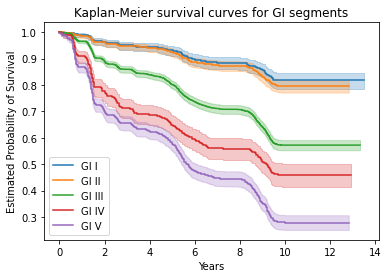

In [30]:
####GI segments

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object


   
GI_I = data.init_GI==1      ## GI == 1 at wave 8
GI_II = data.init_GI==2      ## GI == 2 at wave 8
GI_III = data.init_GI==3      ## GI == 3 at wave 8
GI_IV = data.init_GI==4      ## GI == 4 at wave 8
GI_V = data.init_GI==5      ## GI == 5 at wave 8


## fit the model for GI I
kmf1.fit(data.time[GI_I], data.event[GI_I], label='GI I')
a1 = kmf1.plot()

## fit the model for GI II
kmf1.fit(data.time[GI_II], data.event[GI_II], label='GI II')
kmf1.plot(ax=a1)

## fit the model for GI III
kmf1.fit(data.time[GI_III], data.event[GI_III], label='GI III')
kmf1.plot(ax=a1)

## fit the model for GI IV
kmf1.fit(data.time[GI_IV], data.event[GI_IV], label='GI IV')
kmf1.plot(ax=a1)

## fit the model for GI V
kmf1.fit(data.time[GI_V], data.event[GI_V], label='GI V')
kmf1.plot(ax=a1,
    title='Kaplan-Meier survival curves for GI segments',
    xlabel='Years',
    ylabel='Estimated Probability of Survival'
);

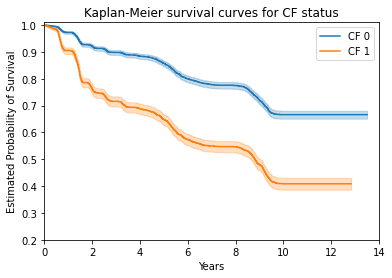

In [31]:
####Example 2

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. Cohort 1. Streaming TV Not Subscribed by users, and Cohort  2. Streaming TV subscribed by the users.
   
CF_0 = data.init_CF==0      ## CF == 0 at wave 8
CF_1 = data.init_CF==1      ## CF == 1 at wave 8


#durations = data.time
#event_observed = data.event


## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='CF 0')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='CF 1')
kmf1.plot(ax=a1,
    title='Kaplan-Meier survival curves for CF status',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

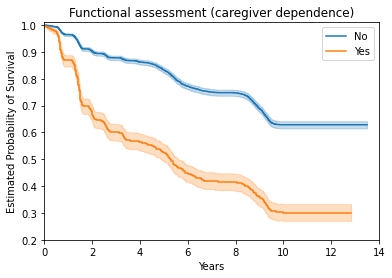

In [32]:
####Functional Assessment

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. Cohort 1. Streaming TV Not Subscribed by users, and Cohort  2. Streaming TV subscribed by the users.
   
CF_0 = data.fun_assess==0      ## CF == 0 at wave 8
CF_1 = data.fun_assess==1      ## CF == 1 at wave 8


#durations = data.time
#event_observed = data.event


## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Functional assessment (caregiver dependence)',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);


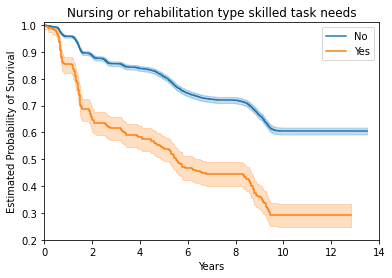

In [33]:
####Nursing type skilled task needs or rehabilitation type skilled task needs

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. Cohort 1. Streaming TV Not Subscribed by users, and Cohort  2. Streaming TV subscribed by the users.
   
CF_0 = data.nrs_rhab==0      ## CF == 0 at wave 8
CF_1 = data.nrs_rhab==1      ## CF == 1 at wave 8


#durations = data.time
#event_observed = data.event


## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Nursing or rehabilitation type skilled task needs',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

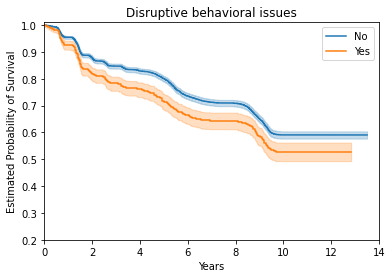

In [34]:
####Disruptive behavioral issues

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. Cohort 1. Streaming TV Not Subscribed by users, and Cohort  2. Streaming TV subscribed by the users.
   
CF_0 = data.disrupt==0      ## CF == 0 at wave 8
CF_1 = data.disrupt==1      ## CF == 1 at wave 8


#durations = data.time
#event_observed = data.event


## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Disruptive behavioral issues',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

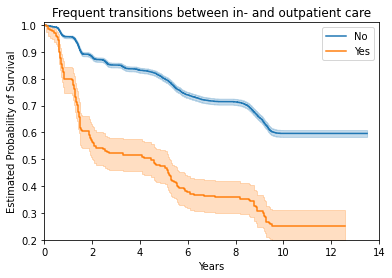

In [35]:
####Frequent transitions between inpatient and outpatient care

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. Cohort 1. Streaming TV Not Subscribed by users, and Cohort  2. Streaming TV subscribed by the users.
   
CF_0 = data.freq_trans==0      ## CF == 0 at wave 8
CF_1 = data.freq_trans==1      ## CF == 1 at wave 8


#durations = data.time
#event_observed = data.event


## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
    title='Frequent transitions between in- and outpatient care',
    xlabel='Years',
    ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);

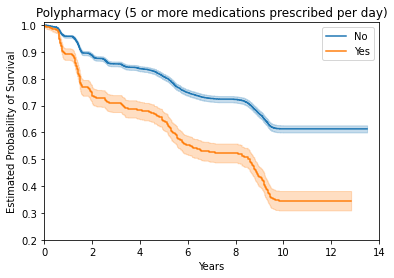

In [36]:
####Polypharmacy

kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. Cohort 1. Streaming TV Not Subscribed by users, and Cohort  2. Streaming TV subscribed by the users.
   
CF_0 = data.polypharm==0      ## CF == 0 at wave 8
CF_1 = data.polypharm==1      ## CF == 1 at wave 8


#durations = data.time
#event_observed = data.event


## fit the model for CF_0
kmf1.fit(data.time[CF_0], data.event[CF_0], label='No')
a1 = kmf1.plot()

## fit the model for CF_0
kmf1.fit(data.time[CF_1], data.event[CF_1], label='Yes')
kmf1.plot(ax=a1,
          title='Polypharmacy (5 or more medications prescribed per day)',
          xlabel='Years',
          ylabel='Estimated Probability of Survival',
          ylim=(0.2,1.01),
          xlim=(-0.01, 14)
);


# Cox Regression

In [37]:
#define data for cox regression
data_cox = pd.DataFrame(data)
#We assessed predictive validity by using the degree to which baseline categorization was associated with mortality. 
#Controlling: Age, age-squared, female
data_cox["age_squared"] = data_cox.age*data_cox.age

#data_cox["female2"] = -3
data_cox.loc[(data_cox.gender=="1.male"),'gender'] = 0
data_cox.loc[(data_cox.gender=="2.female"),'gender'] = 1
data_cox.rename(columns = {'gender':'female'}, inplace = True)

#Create dummy variables for GI I
data_cox["init_GI_I"] = 0
data_cox.loc[(data_cox.init_GI==1),'init_GI_I'] = 1
#Create dummy variables for GI II
data_cox["init_GI_II"] = 0
data_cox.loc[(data_cox.init_GI==2),'init_GI_II'] = 1
#Create dummy variables for GI III
data_cox["init_GI_III"] = 0
data_cox.loc[(data_cox.init_GI==3),'init_GI_III'] = 1
#Create dummy variables for GI IV
data_cox["init_GI_IV"] = 0
data_cox.loc[(data_cox.init_GI==4),'init_GI_IV'] = 1
#Create dummy variables for GI V
data_cox["init_GI_V"] = 0
data_cox.loc[(data_cox.init_GI==5),'init_GI_V'] = 1

#Create severe variables
data_cox["init_GI_severe"] = 0
data_cox.loc[(data_cox.init_GI==4),'init_GI_severe'] = 1
data_cox.loc[(data_cox.init_GI==5),'init_GI_severe'] = 1

data_cox = data_cox[['init_GI_severe', 'init_GI', 'init_CF', 'init_GI_I', 'init_GI_II', 'init_GI_III', 'init_GI_IV', 'init_GI_V', 'fun_assess', 'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 'event', 'time', 'age', 'age_squared', 'female']]

data_cox_GI_CF = data_cox[['init_GI_II', 'init_GI_III', 'init_GI_IV', 'init_GI_V', 'init_CF', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_GI_all = data_cox[['init_GI_II', 'init_GI_III', 'init_GI_IV', 'init_GI_V', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_CF = data_cox[['init_CF', 'event', 'time', 'age', 'age_squared', 'female']]
#data_cox_GI = data_cox[['init_GI_severe', 'event', 'time', 'age', 'age_squared', 'female']]
#data_cox_GI_severe = data_cox[['init_GI_severe', 'event', 'time', 'age', 'age_squared', 'female']]
#data_cox_GI_severe_CF = data_cox[['init_GI_severe', 'init_CF', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_GI_I = data_cox[['init_GI_I', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_GI_II = data_cox[['init_GI_II', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_GI_III = data_cox[['init_GI_III', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_GI_IV = data_cox[['init_GI_IV', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_GI_V = data_cox[['init_GI_V', 'event', 'time', 'age', 'age_squared', 'female']]

data_cox_CF_all = data_cox[['fun_assess', 'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_CF_fun_assess = data_cox[['fun_assess', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_CF_nrs_rhab = data_cox[['nrs_rhab', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_CF_disrupt = data_cox[['disrupt', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_CF_freq_trans = data_cox[['freq_trans', 'event', 'time', 'age', 'age_squared', 'female']]
data_cox_CF_polypharm = data_cox[['polypharm', 'event', 'time', 'age', 'age_squared', 'female']]



data_cox











#Convergence halted due to matrix inversion problems. Suspicion is high collinearity.



,init_GI_severe,init_GI,init_CF,init_GI_I,init_GI_II,init_GI_III,init_GI_IV,init_GI_V,fun_assess,nrs_rhab,disrupt,freq_trans,polypharm,event,time,age,age_squared,female
0,0,3.0,0,0,0,1,0,0,0,0,0,0,0,1.0,5.679151,70.166667,4923.361111,0
1,0,3.0,1,0,0,1,0,0,0,0,1,0,0,1.0,8.890237,67.500000,4556.250000,1
2,1,5.0,1,0,0,0,0,1,0,0,0,0,1,1.0,4.726507,66.416667,4411.173611,0
3,0,2.0,0,0,1,0,0,0,0,0,0,0,0,0.0,12.083333,60.083333,3610.006944,1
4,0,3.0,1,0,0,1,0,0,1,0,0,0,1,1.0,6.170710,68.083333,4635.340278,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7153,1,5.0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.179151,56.416667,3182.840278,1
7154,0,3.0,1,0,0,1,0,0,0,0,1,0,0,0.0,12.166667,57.416667,3296.673611,1
7155,0,3.0,0,0,0,1,0,0,0,0,0,0,0,0.0,11.583333,54.750000,2997.562500,0
7156,0,3.0,0,0,0,1,0,0,0,0,0,0,0,0.0,7.916667,57.000000,3249.000000,0


<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20710.37
         time fit was run = 2023-03-19 18:18:03 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_II   -0.17       0.84       0.11            -0.39             0.05                 0.68                 1.05
init_GI_III   0.49       1.63       0.10             0.30             0.68                 1.35                 1.98
init_GI_IV    0.96       2.61       0.11             0.74             1.17                 2.10                 3.23
init_GI_V     1.11       3.03       0.10             0.91             1.31                 2.48                 3.70
init_CF       0.42       1.52       0.04             0.34             0.51                 1.40                 1.66
age           0.06       1.07       0.03             0.01             0.12                 1.01                 1.12
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.36       0.70       0.04            -0.44            -0.28                 0.65                 0.75

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_II      0.00 -1.52   0.13       2.96
init_GI_III     0.00  5.09 <0.005      21.39
init_GI_IV      0.00  8.74 <0.005      58.58
init_GI_V       0.00 10.92 <0.005      89.80
init_CF         0.00  9.82 <0.005      73.13
age             0.00  2.35   0.02       5.73
age_squared     0.00  1.03   0.30       1.72
female          0.00 -9.09 <0.005      63.10
---
Concordance = 0.78
Partial AIC = 41436.75
log-likelihood ratio test = 2862.05 on 8 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

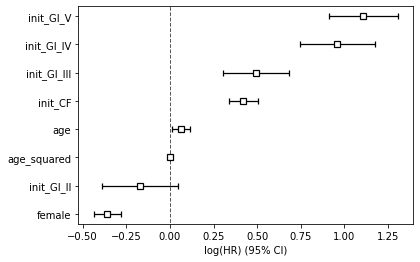

In [38]:
cphGI_CF = CoxPHFitter()
cphGI_CF.fit(data_cox_GI_CF, "time", event_col="event")
cphGI_CF.print_summary()
cphGI_CF.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20758.15
         time fit was run = 2023-03-19 18:18:05 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_II   -0.17       0.85       0.11            -0.39             0.05                 0.68                 1.05
init_GI_III   0.56       1.76       0.10             0.38             0.75                 1.46                 2.12
init_GI_IV    1.09       2.96       0.11             0.87             1.30                 2.39                 3.66
init_GI_V     1.33       3.79       0.10             1.14             1.52                 3.12                 4.59
age           0.05       1.05       0.03            -0.00             0.11                 1.00                 1.11
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.33       0.72       0.04            -0.41            -0.25                 0.66                 0.78

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_II      0.00 -1.50   0.13       2.90
init_GI_III     0.00  5.86 <0.005      27.65
init_GI_IV      0.00  9.99 <0.005      75.63
init_GI_V       0.00 13.48 <0.005     135.11
age             0.00  1.95   0.05       4.28
age_squared     0.00  1.45   0.15       2.77
female          0.00 -8.37 <0.005      54.00
---
Concordance = 0.78
Partial AIC = 41530.30
log-likelihood ratio test = 2766.50 on 7 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

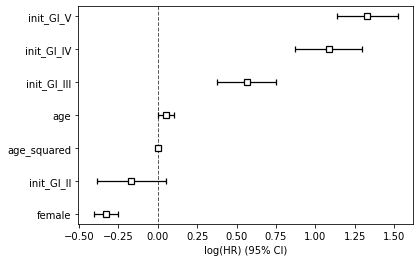

In [39]:
cphGI = CoxPHFitter()
cphGI.fit(data_cox_GI_all, "time", event_col="event")
cphGI.print_summary()
cphGI.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20901.33
         time fit was run = 2023-03-19 18:18:06 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_CF       0.73       2.07       0.04             0.65             0.80                 1.91                 2.24
age           0.06       1.06       0.03             0.01             0.11                 1.01                 1.12
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.39       0.68       0.04            -0.46            -0.31                 0.63                 0.74

              cmp to     z      p   -log2(p)
covariate                                   
init_CF         0.00 18.22 <0.005     243.98
age             0.00  2.33   0.02       5.65
age_squared     0.00  1.28   0.20       2.31
female          0.00 -9.74 <0.005      72.12
---
Concordance = 0.76
Partial AIC = 41810.67
log-likelihood ratio test = 2480.13 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

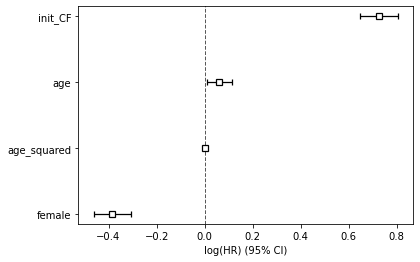

In [40]:
cphCF = CoxPHFitter()
cphCF.fit(data_cox_CF, "time", event_col="event")
cphCF.print_summary()
cphCF.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21031.49
         time fit was run = 2023-03-19 18:18:08 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_I    -0.66       0.51       0.09            -0.85            -0.48                 0.43                 0.62
age           0.02       1.02       0.03            -0.03             0.07                 0.97                 1.07
age_squared   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
female       -0.35       0.70       0.04            -0.43            -0.27                 0.65                 0.76

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_I       0.00 -7.08 <0.005      39.37
age             0.00  0.68   0.49       1.02
age_squared     0.00  2.98 <0.005       8.43
female          0.00 -8.92 <0.005      60.88
---
Concordance = 0.74
Partial AIC = 42070.97
log-likelihood ratio test = 2219.82 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

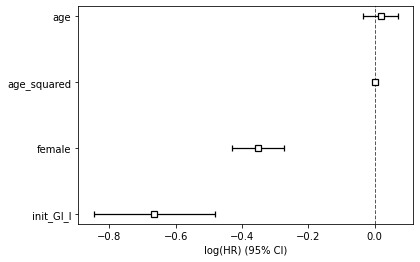

In [41]:
cphGI_I = CoxPHFitter()
cphGI_I.fit(data_cox_GI_I, "time", event_col="event")
cphGI_I.print_summary()
cphGI_I.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20943.44
         time fit was run = 2023-03-19 18:18:09 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_II   -0.93       0.40       0.07            -1.06            -0.79                 0.35                 0.45
age           0.05       1.05       0.03            -0.00             0.10                 1.00                 1.11
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.30       0.74       0.04            -0.38            -0.23                 0.68                 0.80

              cmp to      z      p   -log2(p)
covariate                                    
init_GI_II      0.00 -13.62 <0.005     137.82
age             0.00   1.95   0.05       4.28
age_squared     0.00   1.72   0.09       3.54
female          0.00  -7.72 <0.005      46.31
---
Concordance = 0.75
Partial AIC = 41894.87
log-likelihood ratio test = 2395.92 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

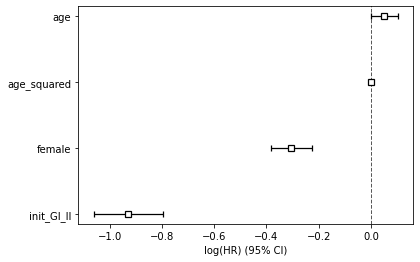

In [42]:
cphGI_II = CoxPHFitter()
cphGI_II.fit(data_cox_GI_II, "time", event_col="event")
cphGI_II.print_summary()
cphGI_II.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21054.96
         time fit was run = 2023-03-19 18:18:11 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_III  -0.15       0.86       0.04            -0.23            -0.07                 0.80                 0.93
age           0.05       1.05       0.03            -0.00             0.10                 1.00                 1.11
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.34       0.71       0.04            -0.42            -0.26                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_III     0.00 -3.75 <0.005      12.47
age             0.00  1.96   0.05       4.31
age_squared     0.00  1.78   0.08       3.74
female          0.00 -8.68 <0.005      57.83
---
Concordance = 0.74
Partial AIC = 42117.93
log-likelihood ratio test = 2172.86 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

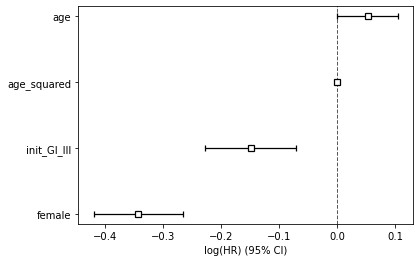

In [43]:
cphGI_III = CoxPHFitter()
cphGI_III.fit(data_cox_GI_III, "time", event_col="event")
cphGI_III.print_summary()
cphGI_III.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21037.94
         time fit was run = 2023-03-19 18:18:12 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_IV    0.46       1.59       0.06             0.34             0.59                 1.41                 1.80
age           0.07       1.07       0.03             0.02             0.12                 1.02                 1.13
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.33       0.72       0.04            -0.41            -0.26                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_IV      0.00  7.34 <0.005      42.12
age             0.00  2.59   0.01       6.69
age_squared     0.00  1.11   0.27       1.90
female          0.00 -8.48 <0.005      55.32
---
Concordance = 0.74
Partial AIC = 42083.88
log-likelihood ratio test = 2206.91 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

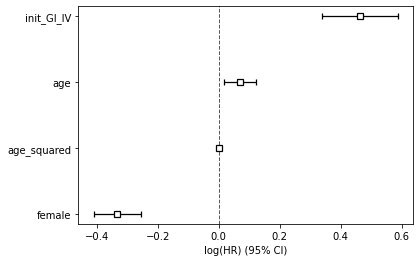

In [44]:
cphGI_IV = CoxPHFitter()
cphGI_IV.fit(data_cox_GI_IV, "time", event_col="event")
cphGI_IV.print_summary()
cphGI_IV.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20881.94
         time fit was run = 2023-03-19 18:18:14 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_GI_V     0.87       2.39       0.04             0.79             0.96                 2.20                 2.60
age           0.04       1.04       0.03            -0.02             0.09                 0.98                 1.09
age_squared   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
female       -0.35       0.71       0.04            -0.43            -0.27                 0.65                 0.76

              cmp to     z      p   -log2(p)
covariate                                   
init_GI_V       0.00 20.20 <0.005     298.93
age             0.00  1.31   0.19       2.40
age_squared     0.00  2.24   0.02       5.33
female          0.00 -8.85 <0.005      59.93
---
Concordance = 0.76
Partial AIC = 41771.89
log-likelihood ratio test = 2518.90 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

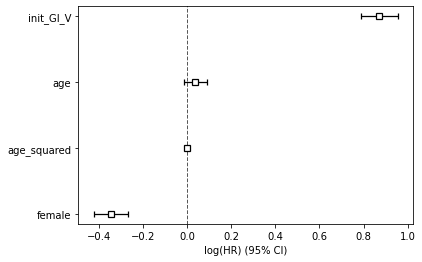

In [45]:
cphGI_V = CoxPHFitter()
cphGI_V.fit(data_cox_GI_V, "time", event_col="event")
cphGI_V.print_summary()
cphGI_V.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20901.33
         time fit was run = 2023-03-19 18:18:15 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
init_CF       0.73       2.07       0.04             0.65             0.80                 1.91                 2.24
age           0.06       1.06       0.03             0.01             0.11                 1.01                 1.12
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.39       0.68       0.04            -0.46            -0.31                 0.63                 0.74

              cmp to     z      p   -log2(p)
covariate                                   
init_CF         0.00 18.22 <0.005     243.98
age             0.00  2.33   0.02       5.65
age_squared     0.00  1.28   0.20       2.31
female          0.00 -9.74 <0.005      72.12
---
Concordance = 0.76
Partial AIC = 41810.67
log-likelihood ratio test = 2480.13 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

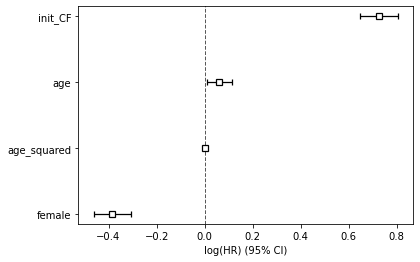

In [46]:
cphCF = CoxPHFitter()
cphCF.fit(data_cox_CF, "time", event_col="event")
cphCF.print_summary()
cphCF.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20846.90
         time fit was run = 2023-03-19 18:18:17 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
fun_assess    0.67       1.95       0.05             0.57             0.76                 1.77                 2.15
nrs_rhab      0.16       1.18       0.06             0.04             0.29                 1.04                 1.34
disrupt       0.37       1.44       0.06             0.25             0.48                 1.29                 1.61
freq_trans    0.31       1.37       0.08             0.16             0.47                 1.17                 1.60
polypharm     0.40       1.49       0.05             0.29             0.51                 1.34                 1.66
age           0.07       1.07       0.03             0.02             0.13                 1.02                 1.13
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.40       0.67       0.04            -0.48            -0.33                 0.62                 0.72

              cmp to      z      p   -log2(p)
covariate                                    
fun_assess      0.00  13.32 <0.005     132.09
nrs_rhab        0.00   2.54   0.01       6.48
disrupt         0.00   6.42 <0.005      32.81
freq_trans      0.00   3.94 <0.005      13.61
polypharm       0.00   7.31 <0.005      41.73
age             0.00   2.64   0.01       6.90
age_squared     0.00   0.87   0.38       1.38
female          0.00 -10.12 <0.005      77.49
---
Concordance = 0.77
Partial AIC = 41709.81
log-likelihood ratio test = 2588.99 on 8 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

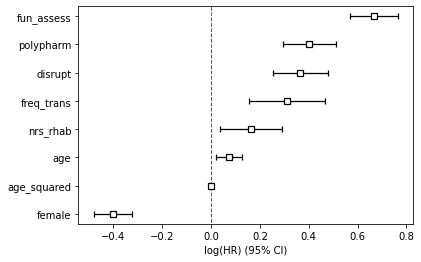

In [47]:
cphCF_all = CoxPHFitter()
cphCF_all.fit(data_cox_CF_all, "time", event_col="event")
cphCF_all.print_summary()
cphCF_all.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20923.16
         time fit was run = 2023-03-19 18:18:18 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
fun_assess    0.84       2.32       0.05             0.75             0.93                 2.11                 2.54
age           0.08       1.08       0.03             0.03             0.13                 1.03                 1.14
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.37       0.69       0.04            -0.45            -0.29                 0.64                 0.75

              cmp to     z      p   -log2(p)
covariate                                   
fun_assess      0.00 17.86 <0.005     234.46
age             0.00  2.94 <0.005       8.23
age_squared     0.00  0.54   0.59       0.77
female          0.00 -9.33 <0.005      66.32
---
Concordance = 0.76
Partial AIC = 41854.31
log-likelihood ratio test = 2436.48 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

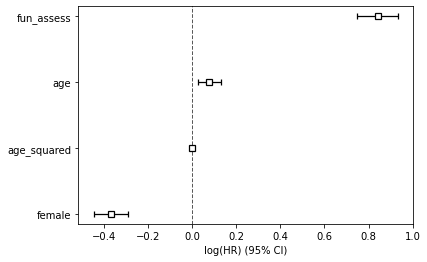

In [48]:
cphCF_fun_assess = CoxPHFitter()
cphCF_fun_assess.fit(data_cox_CF_fun_assess, "time", event_col="event")
cphCF_fun_assess.print_summary()
cphCF_fun_assess.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21032.06
         time fit was run = 2023-03-19 18:18:20 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
nrs_rhab      0.50       1.65       0.06             0.38             0.62                 1.46                 1.86
age           0.05       1.05       0.03             0.00             0.10                 1.00                 1.11
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.34       0.71       0.04            -0.42            -0.27                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
nrs_rhab        0.00  8.19 <0.005      51.78
age             0.00  1.99   0.05       4.42
age_squared     0.00  1.69   0.09       3.46
female          0.00 -8.72 <0.005      58.26
---
Concordance = 0.74
Partial AIC = 42072.12
log-likelihood ratio test = 2218.68 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

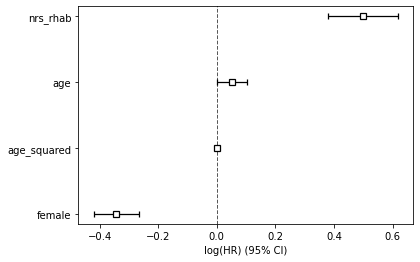

In [49]:
cphCF_nrs_rhab = CoxPHFitter()
cphCF_nrs_rhab.fit(data_cox_CF_nrs_rhab, "time", event_col="event")
cphCF_nrs_rhab.print_summary()
cphCF_nrs_rhab.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21013.61
         time fit was run = 2023-03-19 18:18:21 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
disrupt       0.58       1.78       0.06             0.47             0.68                 1.60                 1.98
age           0.05       1.05       0.03            -0.00             0.10                 1.00                 1.11
age_squared   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
female       -0.39       0.68       0.04            -0.47            -0.31                 0.63                 0.73

              cmp to     z      p   -log2(p)
covariate                                   
disrupt         0.00 10.48 <0.005      82.96
age             0.00  1.94   0.05       4.25
age_squared     0.00  1.86   0.06       4.00
female          0.00 -9.73 <0.005      71.85
---
Concordance = 0.75
Partial AIC = 42035.23
log-likelihood ratio test = 2255.57 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

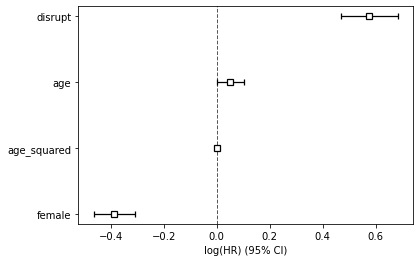

In [50]:
cphCF_disrupt = CoxPHFitter()
cphCF_disrupt.fit(data_cox_CF_disrupt, "time", event_col="event")
cphCF_disrupt.print_summary()
cphCF_disrupt.plot()

In [51]:
#cphCF_soc_sup = CoxPHFitter()
#cphCF_soc_sup.fit(data_cox_CF_soc_sup, "time", event_col="event")
#cphCF_soc_sup.print_summary()
#cphCF_soc_sup.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -21034.94
         time fit was run = 2023-03-19 18:18:22 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
freq_trans    0.66       1.93       0.08             0.49             0.82                 1.63                 2.28
age           0.04       1.04       0.03            -0.01             0.09                 0.99                 1.10
age_squared   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
female       -0.34       0.71       0.04            -0.42            -0.26                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
freq_trans      0.00  7.78 <0.005      46.98
age             0.00  1.56   0.12       3.08
age_squared     0.00  2.15   0.03       4.99
female          0.00 -8.59 <0.005      56.71
---
Concordance = 0.74
Partial AIC = 42077.88
log-likelihood ratio test = 2212.91 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

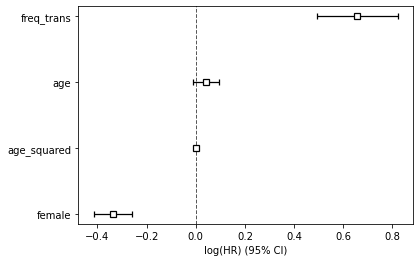

In [52]:
cphCF_freq_trans = CoxPHFitter()
cphCF_freq_trans.fit(data_cox_CF_freq_trans, "time", event_col="event")
cphCF_freq_trans.print_summary()
cphCF_freq_trans.plot()

<lifelines.CoxPHFitter: fitted with 7158 total observations, 4557 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7158
number of events observed = 2601
   partial log-likelihood = -20979.05
         time fit was run = 2023-03-19 18:18:24 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
polypharm     0.71       2.03       0.05             0.61             0.81                 1.83                 2.24
age           0.02       1.02       0.03            -0.03             0.07                 0.97                 1.07
age_squared   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
female       -0.34       0.71       0.04            -0.42            -0.27                 0.66                 0.77

              cmp to     z      p   -log2(p)
covariate                                   
polypharm       0.00 13.89 <0.005     143.32
age             0.00  0.73   0.46       1.11
age_squared     0.00  2.99 <0.005       8.48
female          0.00 -8.75 <0.005      58.71
---
Concordance = 0.75
Partial AIC = 41966.10
log-likelihood ratio test = 2324.69 on 4 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

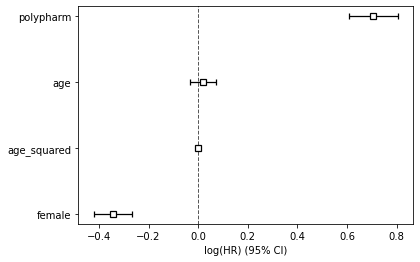

In [53]:
cphCF_polypharm = CoxPHFitter()
cphCF_polypharm.fit(data_cox_CF_polypharm, "time", event_col="event")
cphCF_polypharm.print_summary()
cphCF_polypharm.plot()